In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime

from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats import proportion
from pingouin import mixed_anova

from psyfun import io, atlas, spikes, plots, util
from psyfun.config import *

## Data Loading & Preparation

Load the metadata for all sessions and units.

In [10]:
# Load the session and unit metadata
df_sessions = pd.read_parquet(paths['sessions'])  # session info
df_sessions = df_sessions.query('n_tasks >= 2').dropna(subset=['task00_spontaneous_start', 'task01_spontaneous_start'])
df_sessions = df_sessions[df_sessions['eid'] != 'e31bff07-d66c-4a03-894d-f71030161ead']

In [11]:
df_units = pd.read_parquet(paths['units'])  # unit info
df_units['coarse_region'] = atlas.coarse_regions(df_units['region'])

Filter low-quality sessions

In [12]:
print(f"Total sessions: {len(df_sessions)}")

# Remove sessions missing timing information for important experimental epochs
task_epochs = ['task00_spontaneous_start', 'task01_spontaneous_start', 'task00_replay_start', 'task01_replay_start']
df_sessions = df_sessions.dropna(subset=task_epochs)


# JA: drop massive outlier from my recordings, this recording should probably be removed from the dataset altogether
# Recording from ZFM-08457 on 2025-03-20, eid: 'e31bff07-d66c-4a03-894d-f71030161ead'
# Notes from recording: No spikes!!! -> SAC!

# DC: I wouldn't be so quick to drop, it has many good units and reasonable firing rate distribution
# eid = 'e31bff07-d66c-4a03-894d-f71030161ead'
# df_session = df_units.query('eid == @eid')
# df_goodunits = df_session.query('ks2_label == "good"')
# print(f"Total units: {len(df_session)}")
# print(f"Good units: {len(df_goodunits)}")
# plt.hist(df_goodunits['firing_rate'])

# To drop the session, run:
# df_sessions = df_sessions[df_sessions['eid'] != 'e31bff07-d66c-4a03-894d-f71030161ead']

print(f"Remaining sessions: {len(df_sessions)}")

Total sessions: 36
Remaining sessions: 36


Filter low-quality units

In [13]:
# Get eids for remaining sessions
eids = df_sessions['eid'].tolist()
df_units = df_units.query('eid in @eids')
print(f"Total units: {len(df_units)}")

# Some useful filters:
unit_filter = 'ks2_label == "good"'  # kilosort label for well-isolated units, as opposed to multi-unit activity (mua)
# unit_filter = 'label == 1.0'  # more conservative IBL quality criterion
# Additional filters can be constructed using any column of the unit metadata
# print(df_units.columns)

# Remove low-quality units
df_units = df_units.query(unit_filter)
print(f"Remaining units: {len(df_units)}")

Total units: 79454
Remaining units: 14886


Load spike times for remaining good units

In [14]:
# Load spike times
df_spiketimes = io.load_units(paths['spikes'], df_units['uuid'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:04<00:00, 3476.30it/s]


Merge spike times, unit info, and session info dataframes

In [15]:
# Join spike times with unit info
df_spikes = df_units.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessions, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns after merge
df_spikes = df_spikes[[col for col in df_spikes.columns if not col.endswith('_x') or col.endswith('_y')]]

### Mean firing rate

In [16]:
# Collect spike counts for each task epoch and get mean rate
epochs = ['task00_spontaneous', 'task01_spontaneous', 'task00_rfm', 'task01_rfm', 'task00_replay', 'task01_replay']

dt = 1  # 1s bins
for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())  # compute mean
    df_spikes[f'{epoch}_lograte'] = np.log10(df_spikes[f'{epoch}_rate'])  # log-transform
# Note: log-transform is applied to normalize mean rate distributions (Buzsáki & Mizuseki, 2014, Nat Rev Neuro)

Getting spike counts for: task00_spontaneous


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:03<00:00, 4376.97it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task01_spontaneous


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 5243.54it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task00_rfm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 5084.60it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task01_rfm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 5306.33it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task00_replay


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 6052.61it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Getting spike counts for: task01_replay


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14886/14886 [00:02<00:00, 6178.29it/s]
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'lograte')

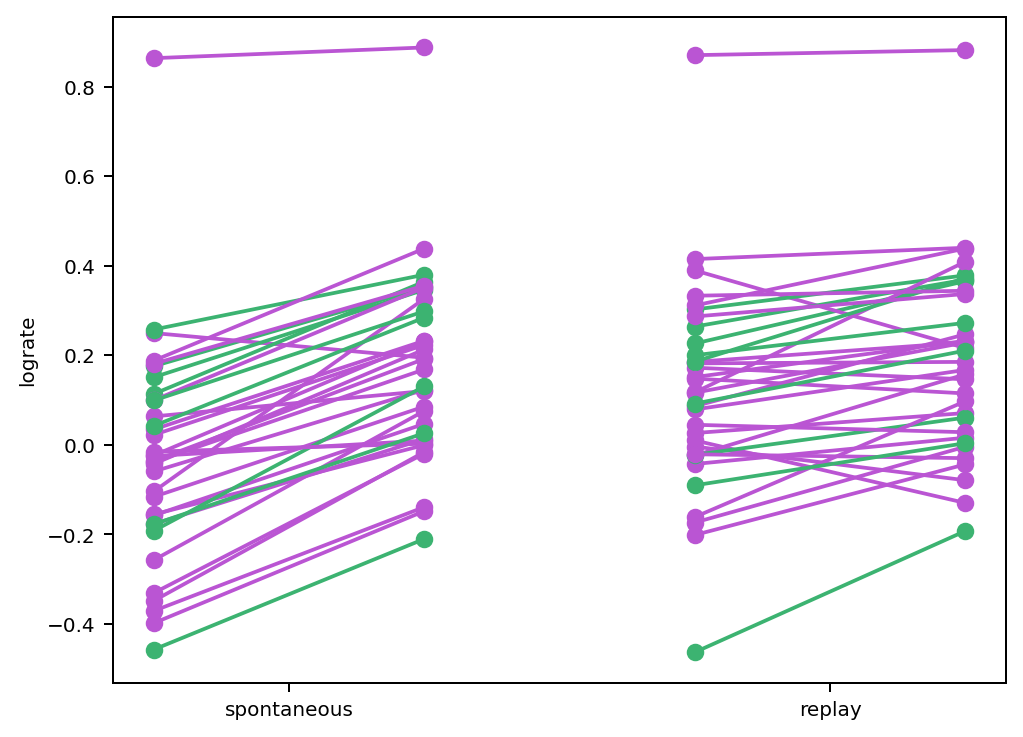

In [17]:
# Plot mean firing rate changes per session (eid)
tasks = ['task00', 'task01']  # here, we split epoch into two separable factors: 1) the task period, pre (00) or post (01) treatment
# epochs = ['spontaneous', 'rfm', 'replay']  # and 2) the experimental epoch
epochs = ['spontaneous', 'replay',]
metric = 'lograte'
xoffset = 0.25
fig, ax = plt.subplots()
for idx, session in df_spikes.groupby('eid'):
    pos = 0
    for epoch in epochs:
        x = pos + np.array([-xoffset, xoffset])
        y = np.array([np.nanmean(session[f'{task}_{epoch}_{metric}'].replace(-np.inf, np.nan)) for task in tasks])
        color = CONTROLCOLOR if session['control_recording'].unique()[0] else LSDCOLOR
        ax.plot(x, y, color=color, marker='o')
        pos += 1
ax.set_xticks(range(len(epochs)))
ax.set_xticklabels(epochs)
ax.set_ylabel(metric)

## Multi-level statistical analysis
- the data has a two-level "cross-classified" nested hierarchical structure:
  - repeated observations are drawn from each neuron across the epoch and task variable
  - different brain regions (sets of neurons) are targeted in different sessions from the same mouse
  - pairs of experimental and control recordings target the same brain regions (across hemispheres) within the same mouse
  - therefore some factors are repeated across individual experimental units, others are across different subsets of experimental units that can be grouped
- FIXME: replace 'subject' grouping variable with composite 'subject_trajectory' to account for within-subject controls
- TODO: assess intra-class correlations for different grouping levels (neurons, insertion trajectories, mice) to see which is strongest

In [19]:
# Convert dataframe to long format
df_rates = df_spikes.melt(
    id_vars=['subject', 'eid', 'uuid', 'control_recording'],
    value_vars=[col for col in df_spikes.columns if col.endswith('_lograte')],
    var_name='epoch',
    value_name='lograte'
).replace(-np.inf, np.nan).dropna()
df_rates['task'] = df_rates['epoch'].apply(lambda x: x.split('_')[0])
df_rates['epoch'] = df_rates['epoch'].apply(lambda x: x.split('_')[1])
df_rates = df_rates[df_rates['epoch'].apply(lambda x: x in epochs)]  # Take only epochs of interest

# Fit model with joint effects and random slopes/intercepts for each eid
model = smf.mixedlm('lograte ~ C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous"))*C(control_recording)', 
                    data=df_rates,
                    groups=df_rates['subject'],  # Group by mouse
                    # Random slopes for all predictors
                    re_formula='~C(task, Treatment("task00")) + C(epoch, Treatment("spontaneous")) + C(control_recording) + C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous")) + C(task, Treatment("task00"))*C(control_recording) + C(task, Treatment("task00"))*C(epoch, Treatment("spontaneous"))*C(control_recording)'
                   )
result = model.fit()
print(result.summary())

# Fit separate models for each experimental epoch
for epoch in epochs:
    df_epoch = df_rates.query('epoch == @epoch')
    # Specify model with joint effects and random slopes/intercepts for each eid
    model = smf.mixedlm('lograte ~ C(task, Treatment("task00")) + C(control_recording) + C(task, Treatment("task00"))*C(control_recording)', 
                        data=df_epoch,
                        groups=df_epoch['subject'],  # Group by mouse
                        re_formula='~C(task, Treatment("task00")) + C(control_recording) + C(task, Treatment("task00"))*C(control_recording)')  # Random slopes for all predictors
    # Fit & summarize
    result = model.fit()
    print(f"Epoch: {epoch}")
    print(result.summary())

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: Converge

                                                                                                        Mixed Linear Model Regression Results
Model:                                                                            MixedLM                                                               Dependent Variable:                                                               lograte    
No. Observations:                                                                 57512                                                                 Method:                                                                           REML       
No. Groups:                                                                       16                                                                    Scale:                                                                            0.7609     
Min. group size:                                                                  767                                   

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Epoch: spontaneous
                                                           Mixed Linear Model Regression Results
Model:                                              MixedLM                                 Dependent Variable:                                 lograte    
No. Observations:                                   28575                                   Method:                                             REML       
No. Groups:                                         16                                      Scale:                                              0.7601     
Min. group size:                                    377                                     Log-Likelihood:                                     -36671.4465
Max. group size:                                    3404                                    Converged:                                          Yes        
Mean group size:                                    1785.9                                              

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


Epoch: replay
                                                           Mixed Linear Model Regression Results
Model:                                              MixedLM                                 Dependent Variable:                                 lograte    
No. Observations:                                   28937                                   Method:                                             REML       
No. Groups:                                         16                                      Scale:                                              0.7622     
Min. group size:                                    390                                     Log-Likelihood:                                     -37176.2502
Max. group size:                                    3436                                    Converged:                                          Yes        
Mean group size:                                    1808.6                                                   

/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


## Firing rate modulation index (MI)

Compute MI for pairs of epochs de-novo.

In [ ]:
# Define pairs of epochs over which to compare firing rates
epoch_pairs = {
    'spontaneous': ['task00_spontaneous', 'task01_spontaneous'],
    'replay': ['task00_replay', 'task01_replay']
}

# Get firing rate MI for all pairs of epochs (Note: this takes some time, so best to load the dataframe if already computed)
# MIs = df_spikes.progress_apply(spikes._apply_modulation_index, epoch_pairs=epoch_pairs, axis='columns')
# df_MI = pd.DataFrame(MIs.to_list(), index=df_spikes.index)
# FIXME: do we need to fix the dtype of the MIs? ...It shouldn't be inconsistent
# df_MI = pd.DataFrame(MIs.to_list(), index=df_spikes.index).map(lambda x: float(x) if isinstance(x, np.ndarray) else x)

In [141]:
# Add to df_spikes
df_spikes = pd.concat([df_spikes, df_MI], axis=1)

# Clean up the columns & save
# columns_to_keep = [
#     'uuid', 'eid', 'subject', 'n_probes', 'n_tasks', 'start_time', 'control_recording', 'session_n',
#     'amp_median', 'contamination', 'drift', 'label', 
#     'x', 'y', 'z', 'region', 'coarse_region',
#     'spontaneous_MI', 'spontaneous_p', 'replay_MI', 'replay_p'
# ]
# df_spikes[columns_to_keep].to_parquet('data/MIs.pqt')

Load previously computed MIs.

In [26]:
df_MI = pd.read_parquet('data/MIs.pqt')
df_spikes = pd.concat([df_spikes, df_MI], axis=1)

Plot MI distributions for each condition.

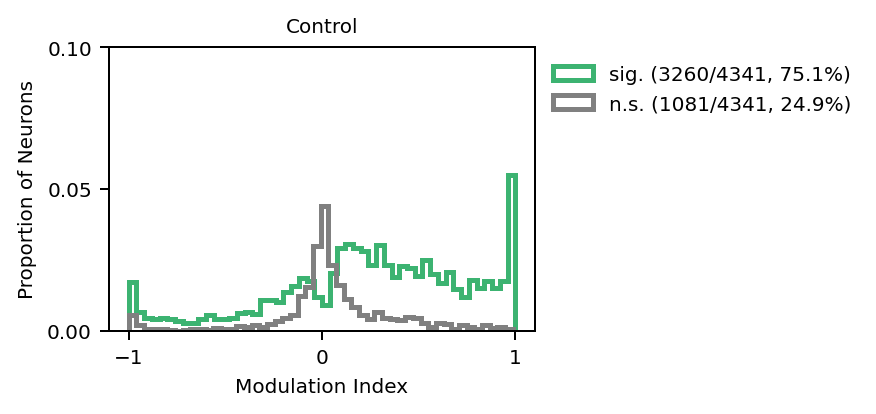

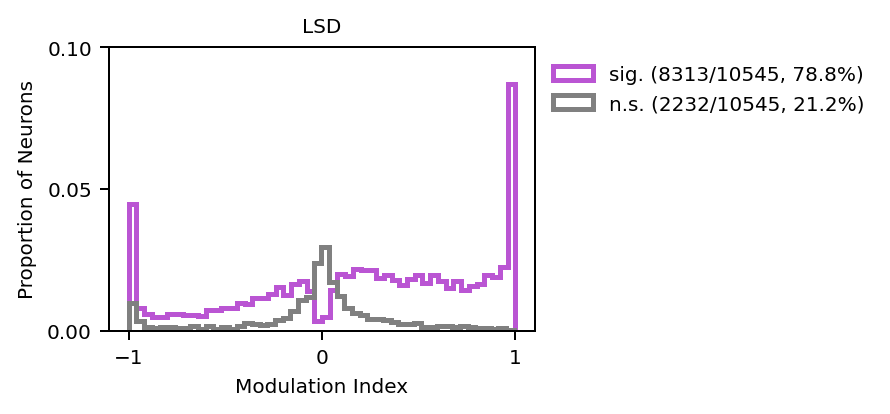

In [27]:
# Define the epoch of interest
epoch = 'spontaneous'

for control in [True, False]:
    fig, ax = plt.subplots()
    title = 'Control' if control else 'LSD'
    ax.set_title(title)
    df_condition = df_MI.query('control_recording == @control')
    
    queries = [
        f'{epoch}_p <= 0.025 or {epoch}_p >= 0.975',
        f'{epoch}_p > 0.025 and {epoch}_p < 0.975'
    ]
    cmap = cmaps['control'] if control else cmaps['LSD']
    colors = [cmap(1.), cmap(0.)]
    
    for query, color, label in zip(queries, colors, ['sig.', 'n.s.']):
        df_sig = df_condition.query(query)
        weights = np.ones(len(df_sig)) / len(df_condition)
        label = f'{label} ({len(df_sig)}/{len(df_condition)}, {len(df_sig)/len(df_condition)*100:.1f}%)'
        ax.hist(df_sig[f'{epoch}_MI'], bins=50, weights=weights, histtype='step', linewidth=2, color=color, label=label)
    
    ax.set_xticks([-1, 0, 1])
    ax.set_xlabel('Modulation Index')
    ax.set_yticks([0, 0.05, 0.1])
    ax.set_ylabel('Proportion of Neurons')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    
    plots.set_plotsize(w=6, h=4)

Anatomical distribution of MIs

In [28]:
# Get coarse anatomical parcellation
df_MI['coarse_region'] = atlas.coarse_regions(df_MI['region'])
df_MI = df_MI.query('(coarse_region != "Fiber tract") and (coarse_region != "None")')  # drop uninformative regions

Proportion of neurons with a significant MI in each region

/tmp/ipykernel_2101141/2962515372.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_significant = df_condition.groupby('coarse_region').apply(lambda x: x[f'{epoch}_significant'].sum())
/tmp/ipykernel_2101141/2962515372.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_significant = df_condition.groupby('coarse_region').apply(lambda x: x[f'{epoch}_significant'].sum())


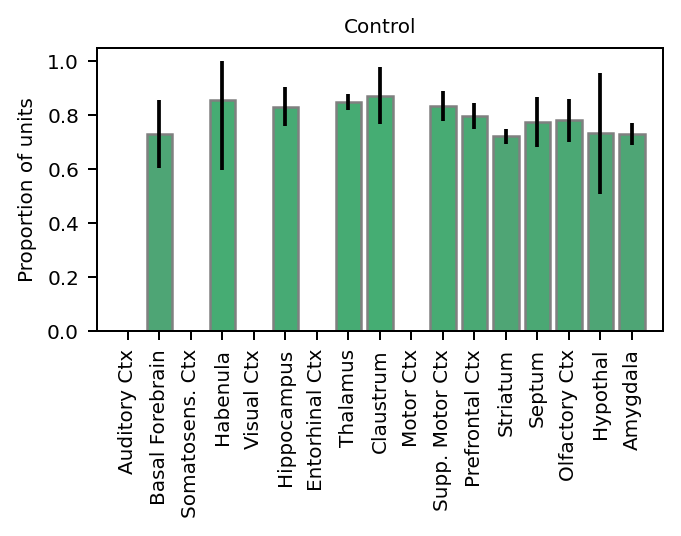

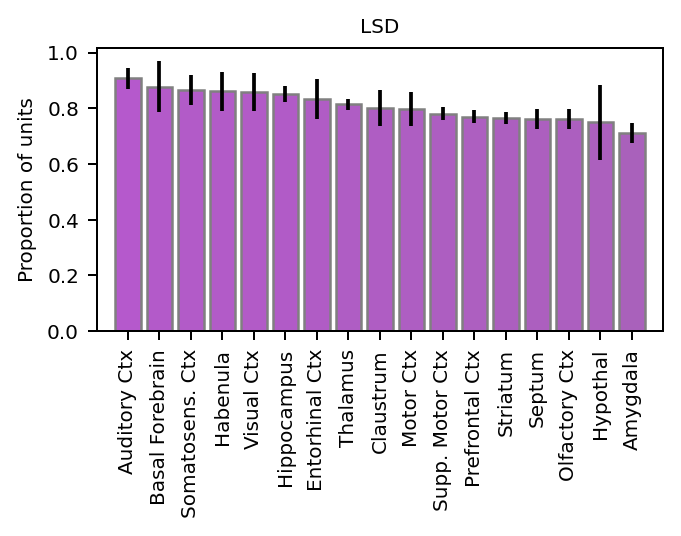

In [39]:
# Define the epoch of interest
epoch = 'spontaneous'

# Perform 2-sided significance test
df_MI[f'{epoch}_significant'] = df_MI[f'{epoch}_p'].apply(lambda x: (x <= 0.025) or (x >= 0.975))
sorted_regions = util.sort_groups(
    df_MI,  # dataframe to sort groups in
    f'{epoch}_significant',  # column with values of interest
    'coarse_region',  # grouping column
    aggfunc=np.mean,  # mean of T/F give proportion True
    reference_condition=('control_recording', False)  # region order determined by sorting LSD recording values
)

# fig, ax = plt.subplots()
for condition in [True, False]:
    # Get data for this condition
    df_condition = df_MI.query('control_recording == @condition')
    
    # Count neurons per region
    n_significant = df_condition.groupby('coarse_region').apply(lambda x: x[f'{epoch}_significant'].sum())
    n_neurons = df_condition.groupby('coarse_region').size()
    
    # Proportion of significant neurons pooled across recordings
    p_significant = (n_significant / n_neurons)
    y_neg, y_pos = proportion.proportion_confint(n_significant, n_neurons, alpha=0.05) # alpha=0.05 specifies a 95% CI
    yerr = np.vstack([p_significant - y_neg, y_pos - p_significant])

    xpos = np.array([sorted_regions[region] for region in p_significant.index])

    cmap = cmaps['control'] if condition else cmaps['LSD']
    colors = np.array([cmap(p) for p in p_significant])

    fig, ax = plt.subplots()
    ax.set_title('Control' if condition else 'LSD')
    ax.bar(xpos, p_significant, yerr=yerr, fc=colors, ec='gray')
    ax.set_xticks(np.fromiter(sorted_regions.values(), dtype=int))
    ax.set_xticklabels(sorted_regions.keys())
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlim([-1, len(sorted_regions)])
    ax.set_ylabel('Proportion of units')
    
    plots.set_plotsize(w=8, h=4)

Mean MI for each region across conditions. Statistical significance assessed with a LMM grouping by subject.

Amygdala: fitting multi-level model with 1 subjects in both conditions
Auditory Ctx: skipping, too few neurons per condition!
Basal Forebrain: fitting multi-level model with 1 subjects in both conditions
Claustrum: reverting to OLS (ANOVA), too few subjects per condition!
Entorhinal Ctx: skipping, too few neurons per condition!
Habenula: skipping, too few neurons per condition!
Hippocampus: fitting multi-level model with 1 subjects in both conditions


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/sta

Hypothal: fitting multi-level model with 1 subjects in both conditions
Motor Ctx: skipping, too few neurons per condition!
Olfactory Ctx: reverting to OLS (ANOVA), too few subjects per condition!
Prefrontal Ctx: fitting multi-level model with 1 subjects in both conditions


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Septum: fitting multi-level model with 1 subjects in both conditions
Somatosens. Ctx: skipping, too few neurons per condition!
Striatum: fitting multi-level model with 1 subjects in both conditions
Supp. Motor Ctx: reverting to OLS (ANOVA), too few subjects per condition!
Thalamus: fitting multi-level model with 1 subjects in both conditions
Visual Ctx: skipping, too few neurons per condition!


/home/davide/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_2101141/2800850767.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pvals = df.groupby('coarse_region').apply(_mixed_lm)


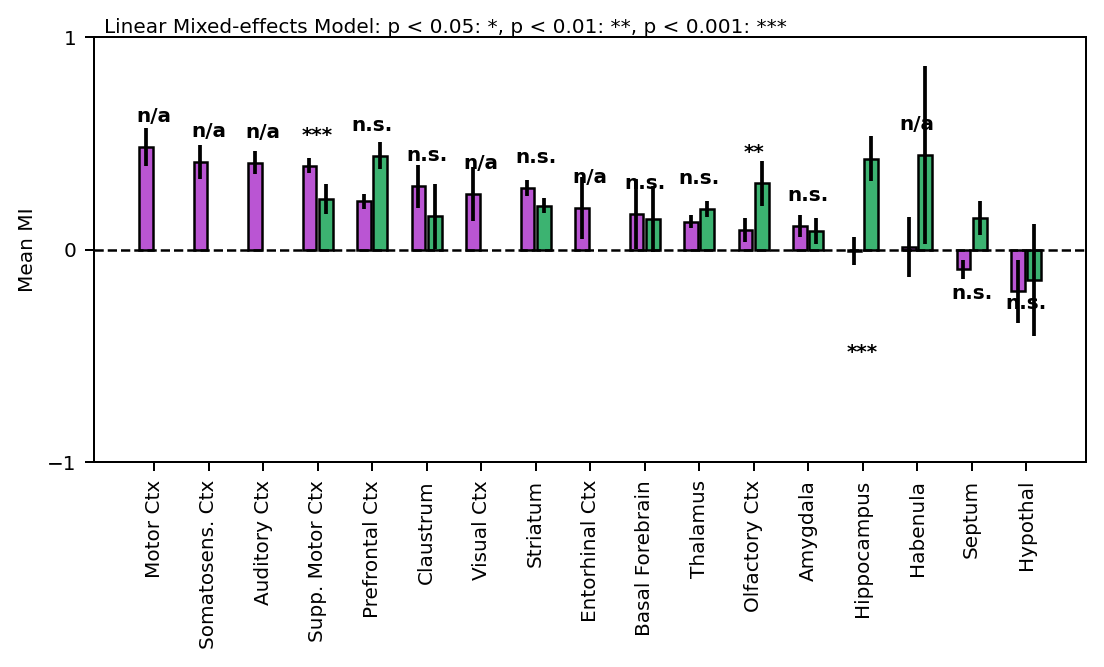

In [36]:
epoch = 'spontaneous'
fig, ax = plt.subplots()

# Prepare data: keep only significant neurons
df = df_MI.dropna(subset=[f'{epoch}_MI']).query(f'{epoch}_p < 0.025 or {epoch}_p > 0.975')

# Compute mean MI per region (all data), for sorting
region_means = df.groupby('coarse_region')[f'{epoch}_MI'].mean()
sorted_regions = region_means.sort_values(ascending=False).index.tolist()

# Compute means and errors for each group (control and LSD/experimental)
MI = df.groupby(['coarse_region', 'control_recording'])[f'{epoch}_MI'].agg(['mean', 'sem']).unstack()

def _mixed_lm(group_data, min_n_neurons=7):
    group_data.reset_index(drop=True, inplace=True)
    min_neurons_per_condition = min(sum(group_data['control_recording'] == True), sum(group_data['control_recording'] == False))
    n_subjects_both_conditions = sum(group_data.groupby('subject')['control_recording'].nunique() == 2)
    
    if min_neurons_per_condition < min_n_neurons:
        print(f"{group_data.name}: skipping, too few neurons per condition!")
        return np.nan
    elif n_subjects_both_conditions < 1:
        print(f"{group_data.name}: reverting to OLS (ANOVA), too few subjects per condition!")
        model = smf.ols(f'{epoch}_MI ~ C(control_recording)', group_data)
        result = model.fit()
    else:
        print(f"{group_data.name}: fitting multi-level model with {n_subjects_both_conditions} subjects in both conditions")
        model = smf.mixedlm(f'{epoch}_MI ~ C(control_recording)', group_data, groups=group_data["subject"], re_formula='~C(control_recording)')
        result = model.fit(method='lbfgs')
        if not result.converged:
            print(f"Model failed to converge for coarse_region {group_data.name}")
            return np.nan
    return result.pvalues['C(control_recording)[T.True]']
pvals = df.groupby('coarse_region').apply(_mixed_lm)

xpos = np.arange(len(sorted_regions))
for control, offset in zip([False, True], [-0.15, 0.15]):
    means = MI['mean'].loc[sorted_regions, control].values
    err   = MI['sem'].loc[sorted_regions, control].values * 1.96
    color = CONTROLCOLOR if control else LSDCOLOR
    ax.bar(xpos + offset, means, yerr=err, width=0.25, color=color, edgecolor='k')

for i, region in enumerate(sorted_regions):
    p = pvals.loc[region]
    h_control = MI['mean'].loc[region, True]
    h_lsd   = MI['mean'].loc[region, False]
    ypos = np.nanmax([np.abs(h_lsd), np.abs(h_control)]) * np.sign(h_lsd)
    ax.text(xpos[i], ypos + (0.1 * np.sign(ypos)), plots.pval2stars(p), ha='center', va='bottom', fontsize=plots.LABELFONTSIZE, fontweight='bold', color='k')

ax.axhline(0, color='k', linewidth=1, linestyle='--')
ax.set_xticks(xpos)
ax.set_xticklabels(sorted_regions, rotation=90)
ax.set_yticks([-1, 0, 1])
ax.set_ylabel('Mean MI')

# ax.text(xpos[0] - 1, 0.01, 'Higher rate after treatment >', fontsize=plots.LABELFONTSIZE, va='bottom', ha='left', rotation=90)
# ax.text(xpos[-1] + 1, -0.01, 'Lower rate after treatment >', fontsize=plots.LABELFONTSIZE, va='top', ha='right', rotation=270)
ax.text(0.01, 1.01, 'Linear Mixed-effects Model: p < 0.05: *, p < 0.01: **, p < 0.001: ***', 
        transform=ax.transAxes, fontsize=plots.LABELFONTSIZE)

plots.set_plotsize(w=14, h=6)

Distribution of MI values per region

TypeError: only integer scalar arrays can be converted to a scalar index

> /tmp/ipykernel_2101141/1303676413.py(27)<module>()
     25     fig, ax = plt.subplots()
     26     cmap = cmaps['control'] if condition else cmaps['LSD']
---> 27     violins = ax.violinplot(MIs[valid_MIs], positions=xpos[valid_MIs], showmedians=False, showextrema=False)
     28     for violin in violins['bodies']:
     29         violin.set_facecolor('none')



ipdb>  c


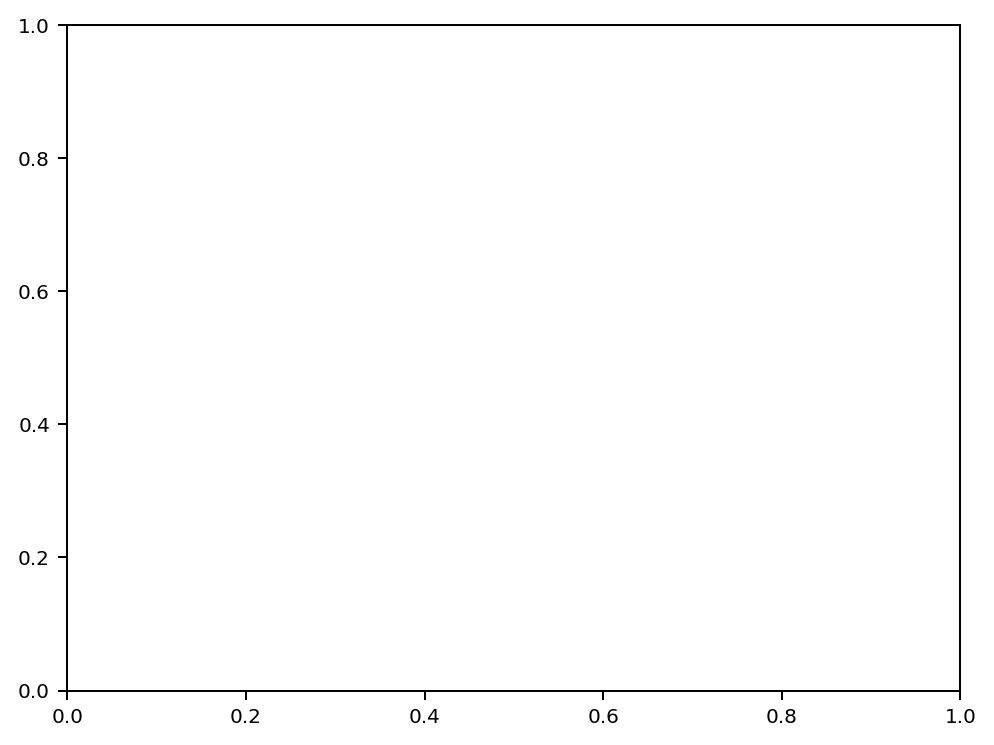

In [58]:
# Define the epoch of interest
epoch = 'spontaneous'

# Sort regions by mean MI
sorted_regions = util.sort_groups(
    df_MI,  # dataframe to sort groups in
    f'{epoch}_MI',  # column with values of interest
    'coarse_region',
    aggfunc=np.mean,
    reference_condition=('control_recording', False)  # region order determined by sorting LSD recording values
)

for condition in [False, True]:
    df_condition = df_MI.query('control_recording == @condition')

    # Loop over regions and ge all MIs
    ## TODO: This is broken, need to find a way to exclude empty regions
    MIs = [df_condition.query('coarse_region == @region')[f'{epoch}_MI'].dropna().values for region in sorted_regions.keys()]
    valid_MIs = np.where([len(mis) > 0 for mis in MIs])
    # cis = [util.bootstrap_median_ci(mi) for mi in sorted_MIs]
    # cis = [np.quantile(mi, [.25, .75]) for mi in sorted_MIs]
    
    # xpos = np.array([sorted_regions[region] for region in MIs.index])
    xpos = np.fromiter(sorted_regions.values(), dtype=int)

    fig, ax = plt.subplots()
    cmap = cmaps['control'] if condition else cmaps['LSD']
    violins = ax.violinplot(MIs[valid_MIs], positions=xpos[valid_MIs], showmedians=False, showextrema=False)
    for violin in violins['bodies']:
        violin.set_facecolor('none')
        violin.set_edgecolor(cmap(1.))
        violin.set_linewidth(1)
        violin.set_alpha(1)
    # for i, (mi, (ci_lower, ci_upper)) in enumerate(zip(sorted_MIs, cis)):
    #     med = np.median(mi)
    #     ax.errorbar(xpos[i], med, yerr=[[med - ci_lower], [ci_upper - med]], fmt='_', color='black')
    ax.axhline(0, ls='--', color='gray')
    for x, units in zip(xpos, MIs):
        ax.text(x - 0.25, 1.05, f'n={len(units)}', fontsize=plots.LABELFONTSIZE, rotation=60)

    ax.set_xticks(np.fromiter(sorted_regions.values(), dtype=int))
    ax.set_xticklabels(sorted_regions.keys())
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('MI')
    ax.set_yticks([-1, 0, 1])
    ax.set_ylim([-1.1, 1.4])
    ax.set_ylabel('Modulation Index')
    ax.set_ylim([-1, 1.5])
    plots.set_plotsize(w=8, h=6)

In [53]:
xpos

array(dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]),
      dtype=object)

### Changepoint detection

In [5]:
df_spikes['LSD_start'] = df_spikes['LSD_admin'] - 5 * 60
df_spikes['LSD_stop'] = df_spikes['LSD_admin'] + 30 * 60

dt = 1
df_spikes[f'LSD_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch='LSD', dt=dt, axis='columns')
df_spikes[f'LSD_rate'] = df_spikes[f'LSD_counts'].apply(lambda x: (x / dt).mean())

100%|███████████████████████████████████| 14886/14886 [00:05<00:00, 2773.85it/s]


In [9]:
import ruptures as rpt

def binseg(y):
    return rpt.Binseg().fit(y).predict(n_bkps=1)

df_spikes['bkpts'] = df_spikes['LSD_counts'].progress_apply(binseg)

100%|█████████████████████████████████████| 14886/14886 [12:47<00:00, 19.41it/s]


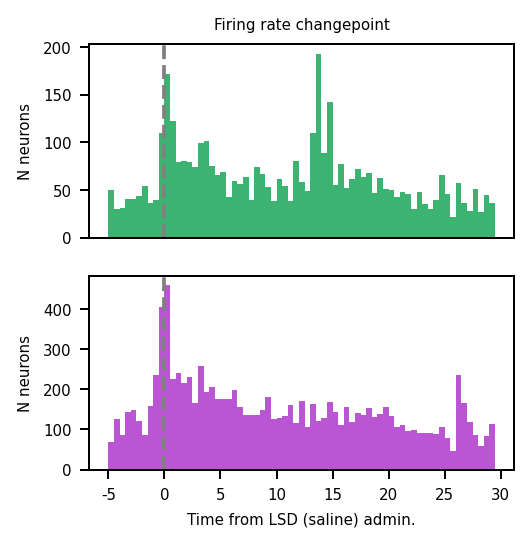

In [38]:
fig, axs = plt.subplots(2)

df = df_spikes.query('control_recording == True')
axs[0].hist(df['bkpts'].apply(lambda x: x[0]), bins=np.arange(0, 35 * 60, 30), color=CONTROLCOLOR)
axs[0].axvline(5 * 60, ls='--', color='gray')
df = df_spikes.query('control_recording == False')
axs[1].hist(df['bkpts'].apply(lambda x: x[0]), bins=np.arange(0, 35 * 60, 30), color=LSDCOLOR)
axs[1].axvline(5 * 60, ls='--', color='gray')

axs[0].set_title('Firing rate changepoint')
axs[0].set_xticks([])
axs[1].set_xticks(np.arange(0, 40 * 60, 300))
axs[1].set_xticklabels(np.arange(0, 40, 5, dtype=int) - 5)
axs[1].set_xlabel('Time from LSD (saline) admin.')
axs[0].set_ylabel('N neurons')
axs[1].set_ylabel('N neurons')

plots.set_plotsize(w=6)